## Notebook for visualizing results from sequential implementation

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys
import jax.numpy as jnp
import jax

from NRT_functions import losses
from NRT_functions import helper_functions
from NRT_functions import plotters

In [54]:
day = '251113'
time = '154117'
counter = 0
save_fig = 0
plot_scale = 1

if counter == '':
    adding_string = ''
else:
    adding_string = '_'

%cd /home/julian/Projects/MasterThesis/ICLR_Actionable_Reps
filepath = './data/' + day + '/' + time + '/'
%cd "$filepath"

# Load parameters
with open('parameters.pkl', 'rb') as pickle_file:
    parameters = pickle.load(pickle_file)

# Load g0 (activity at origin) instead of W
with open('g0' + adding_string + f'{counter}.pkl', 'rb') as pickle_file:
    g0 = pickle.load(pickle_file)

# Load frequencies
with open('om'+ adding_string + f'{counter}.pkl', 'rb') as pickle_file:
    om = pickle.load(pickle_file)

# Load transformation matrix S
with open('S'+ adding_string + f'{counter}.pkl', 'rb') as pickle_file:
    S = pickle.load(pickle_file)

# Load losses
with open('min_L'+ adding_string + f'{counter}.pkl', 'rb') as pickle_file:
    min_L = pickle.load(pickle_file)

with open('L'+ adding_string + f'{counter}.pkl', 'rb') as pickle_file:
    L = pickle.load(pickle_file)

# Load initial values
with open('g0_init'+ adding_string + f'{counter}.pkl', 'rb') as pickle_file:
    g0_init = pickle.load(pickle_file)

with open('S_init'+ adding_string + f'{counter}.pkl', 'rb') as pickle_file:
    S_init = pickle.load(pickle_file)

# Load final values
try:
    with open('g0_final'+ adding_string + f'{counter}.pkl', 'rb') as pickle_file:
        g0_final = pickle.load(pickle_file)
except:
    g0_final = g0

try:
    with open('S_final'+ adding_string + f'{counter}.pkl', 'rb') as pickle_file:
        S_final = pickle.load(pickle_file)
except:
    S_final = S

# Use final values if min loss is poor
if min_L[0] < 1:
    g0 = g0_final
    S = S_final

# Compute D from g0 shape
D = g0.shape[0]
M = int((D - 1) / 2)

print(f"Loaded optimization results:")
print(f"  D = {D}, M = {M}")
print(f"  g0 shape: {g0.shape}")
print(f"  S shape: {S.shape}")
print(f"  om shape: {om.shape}")
print(f"  Min loss: {min_L[1]:.5f}")

/home/julian/Projects/MasterThesis/ICLR_Actionable_Reps
/home/julian/Projects/MasterThesis/ICLR_Actionable_Reps/data/251113/154117
Loaded optimization results:
  D = 65, M = 32
  g0 shape: (65, 1)
  S shape: (65, 65)
  om shape: (32, 2)
  Min loss: 0.00090


In [55]:
# Helper function to compute g(phi) from g0 using transformation
def compute_g_at_positions(g0, om, S, phi):
    """
    Compute g(phi) = T(phi) @ g0 where T(phi) = S @ T_irrep(phi) @ S^(-1)
    
    Args:
        g0: activity at origin, shape [D, 1]
        om: frequencies, shape [M, 2]
        S: change of basis matrix, shape [D, D]
        phi: positions, shape [N, 2]
    
    Returns:
        g: activity at positions, shape [D, N]
    """
    # Apply softplus and normalize (same as in loss functions)
    g0_processed = jax.nn.softplus(g0)
    g0_processed = g0_processed / jnp.linalg.norm(g0_processed)
    
    # Get transformation matrices
    T = helper_functions.get_T_2D(om, phi, S)
    
    # Apply transformation
    g = jnp.einsum('nij,jk->nik', T, g0_processed)
    g = g[:, :, 0].T  # Reshape to [D, N]
    
    return g

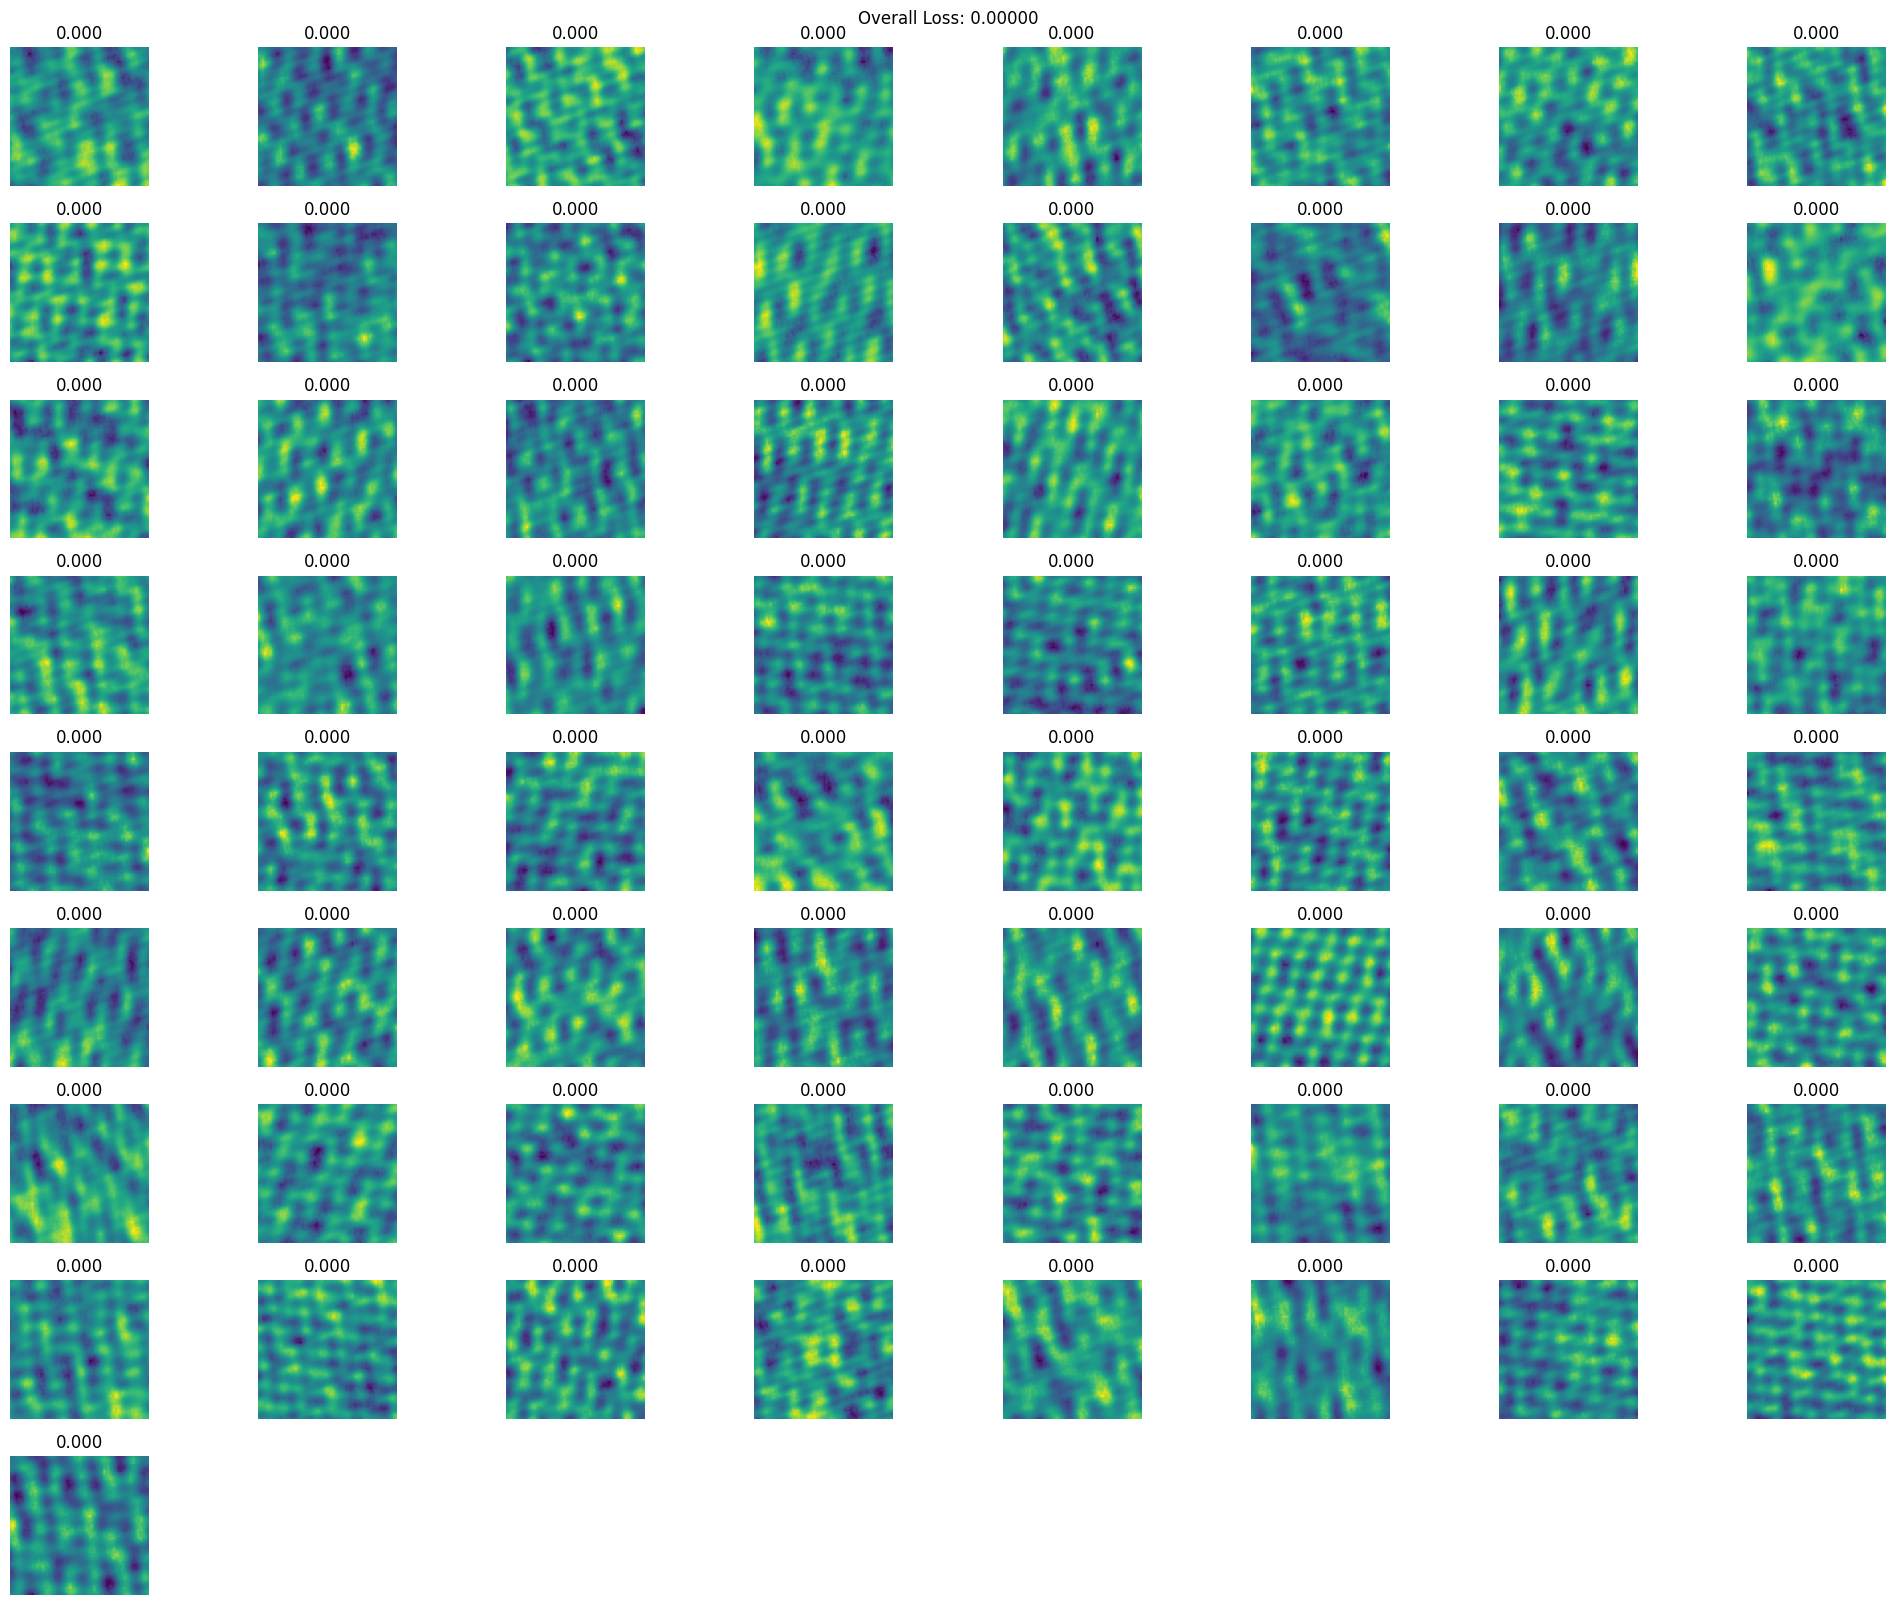

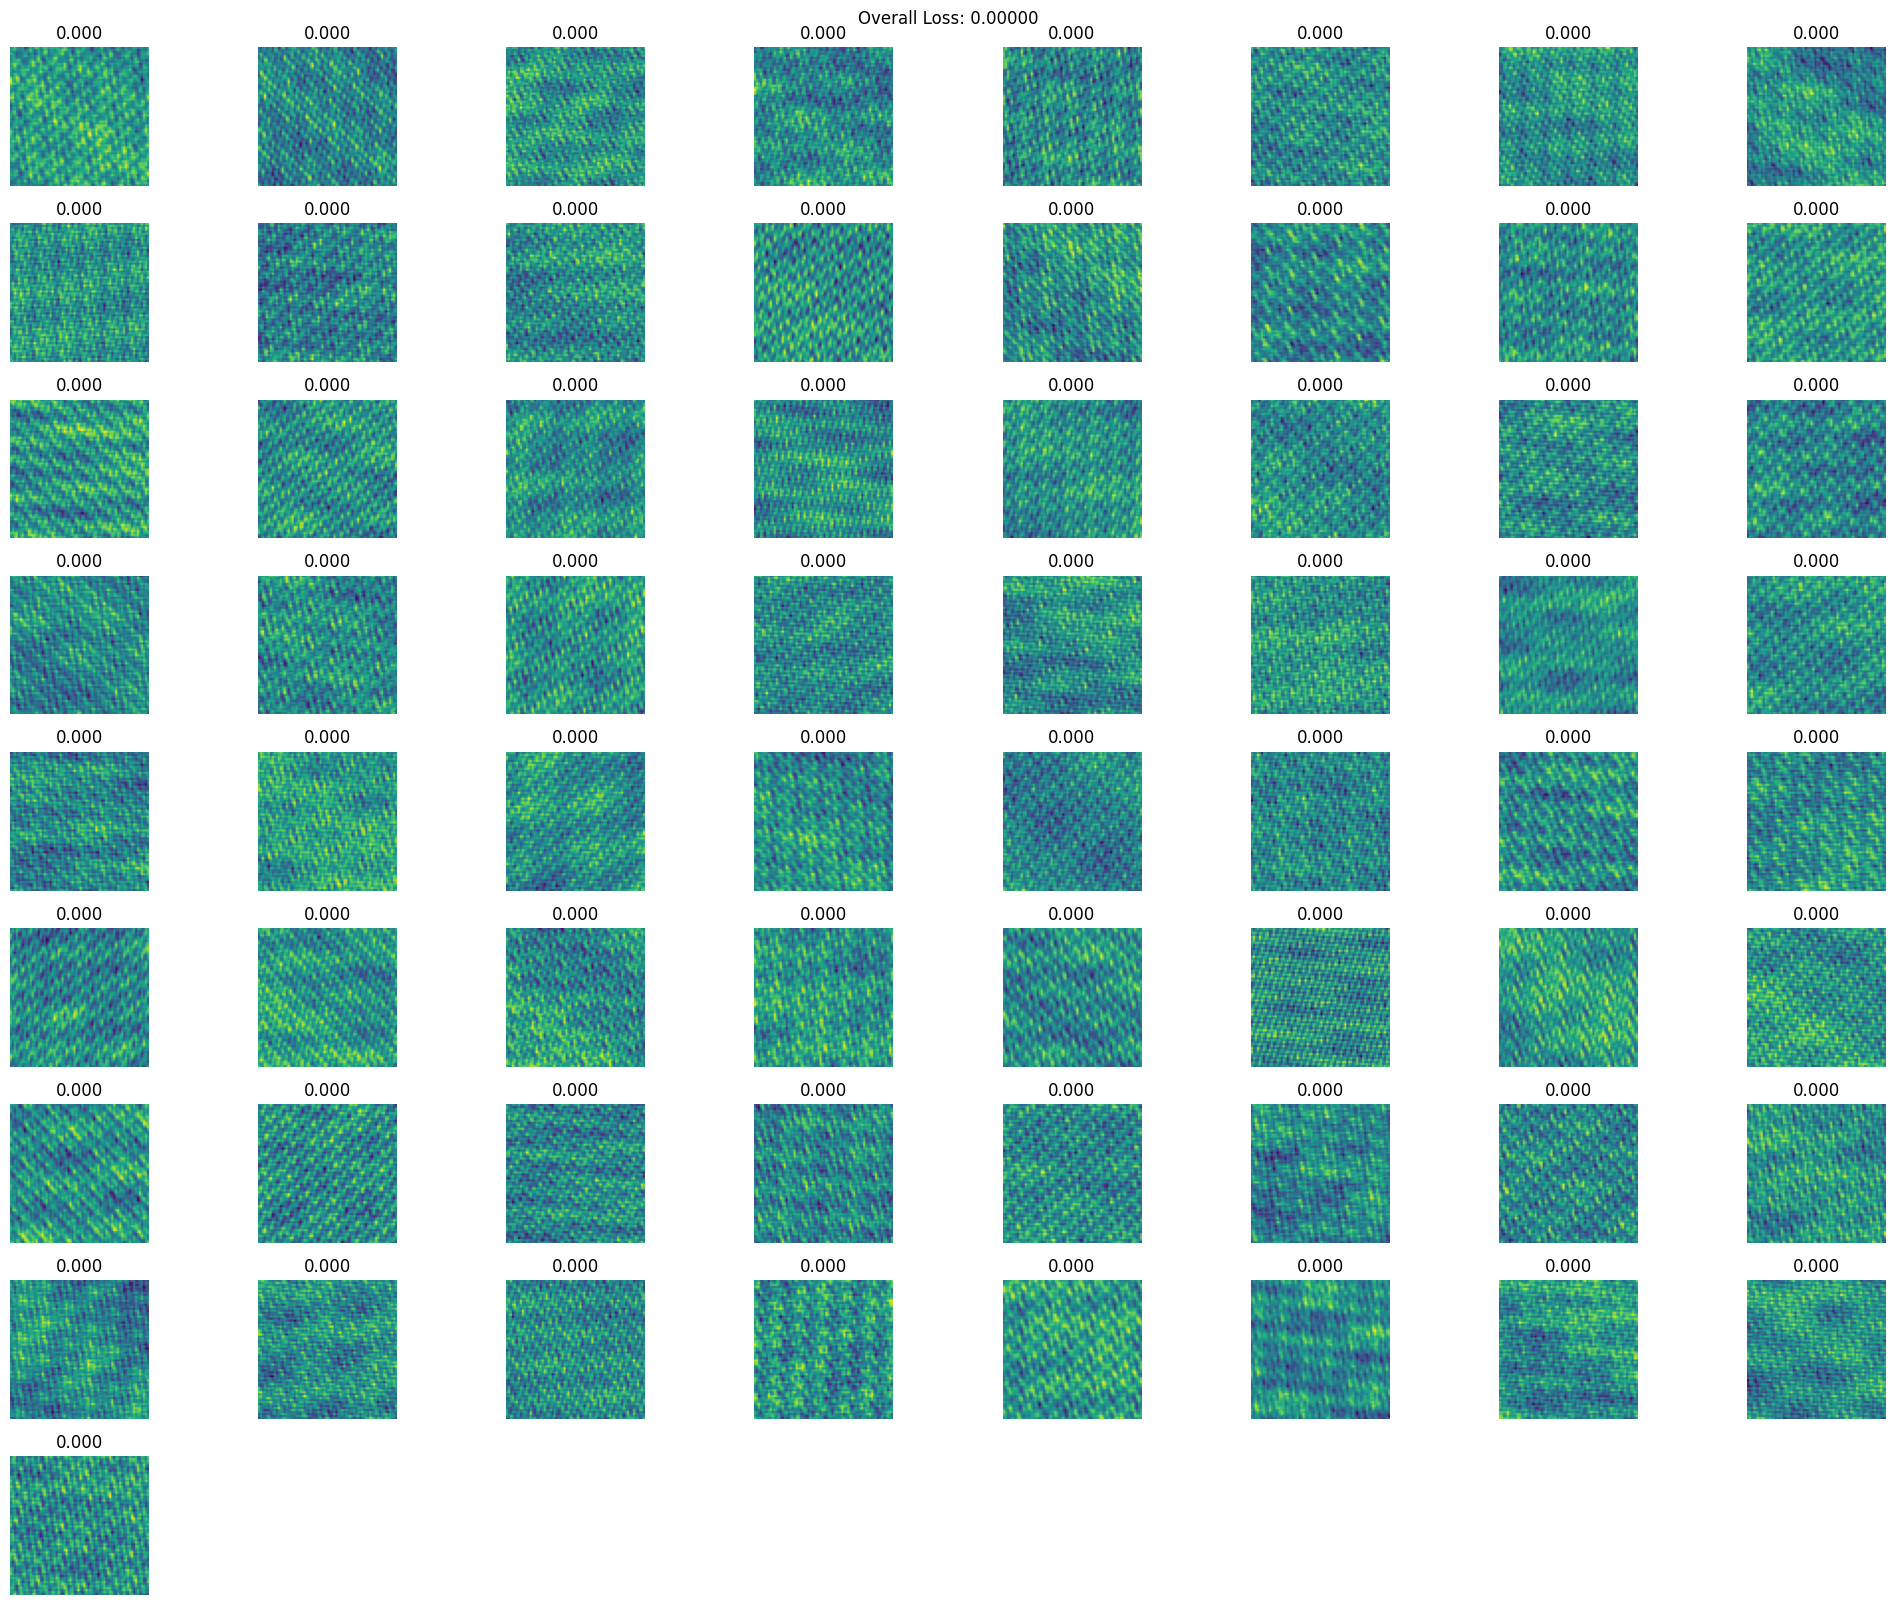

Overall separation loss: 0.00000
Mean neuron loss: 0.00000
Min neuron loss: 0.00000
Max neuron loss: 0.00000


In [56]:
# Visualize 2D plane results
if parameters["dim"] == 2:
    # Create grid of positions
    N_plot = 70
    phi_plot_small = np.linspace(-np.pi, np.pi, N_plot)/2
    phi_plot_small = np.meshgrid(phi_plot_small, phi_plot_small)
    phi_plot_small = np.hstack([np.ndarray.flatten(phi_plot_small[0])[:,None], 
                                 np.ndarray.flatten(phi_plot_small[1])[:,None]])
    
    phi_plot_large = np.linspace(-np.pi, np.pi, N_plot)*parameters.get("pos_lengthscale", 2)*plot_scale
    phi_plot_large = np.meshgrid(phi_plot_large, phi_plot_large)
    phi_plot_large = np.hstack([np.ndarray.flatten(phi_plot_large[0])[:,None], 
                                 np.ndarray.flatten(phi_plot_large[1])[:,None]])
    
    # Compute activities using transformation
    V_small = np.array(compute_g_at_positions(g0, om, S, phi_plot_small))
    V_large = np.array(compute_g_at_positions(g0, om, S, phi_plot_large))
    
    # Normalize by large room norms
    large_norms = np.linalg.norm(V_large, axis=0, keepdims=True)
    V_small = V_small / large_norms
    V_large = V_large / large_norms
    
    # Calculate losses per neuron
    if parameters["sampling_choice"] == 1:
        phi_calc = np.random.normal(0, 1, [N_plot*N_plot, 2])
    elif parameters['sampling_choice'] == 0 or parameters['sampling_choice'] == 2:
        r = np.sqrt(np.random.uniform(size=[N_plot*N_plot, 1]))
        theta = np.random.uniform(size=[N_plot*N_plot, 1]) * 2 * np.pi
        phi_calc = np.hstack([r * np.cos(theta), r * np.sin(theta)])
    else:
        phi_calc = phi_plot_small
    
    neur_losses = np.zeros(D)
    sigma_sq = parameters.get("sigma_sq", 0.04)
    sigma_theta = parameters.get("sigma_theta", 0.5)
    f = parameters.get("f", 1)
    chi = helper_functions.calc_chi_plane(phi_calc, sigma_theta, f)
    
    # Calculate loss for each neuron
    for neuron in range(D):
        g0_neuron = g0[neuron:neuron+1, :]
        neur_losses[neuron] = losses.sep_plane_KernChi_seq(g0_neuron, om, S, phi_calc, sigma_sq, chi)
    
    # Overall loss
    overall_loss = losses.sep_plane_KernChi_seq(g0, om, S, phi_calc, sigma_sq, chi)
    
    Vs = [V_small, V_large]
    phi_plots = [phi_plot_small, phi_plot_large]
    
    # Plot neurons
    RowsD = int(np.ceil(np.sqrt(D)))
    ColumnsD = int(np.ceil(D/RowsD))
    
    for (plot_counter, V_plot) in enumerate(Vs):
        fig = plt.figure(figsize=(20, 16))
        for neuron in range(D):
            plt.subplot(RowsD, ColumnsD, neuron + 1)
            plt.axis('off')
            plt.imshow(np.reshape(V_plot[neuron, :], [N_plot, N_plot]))
            plt.title(f"{neur_losses[neuron]:.3f}")
        fig.tight_layout()
        plt.suptitle(f'Overall Loss: {overall_loss:.5f}', y=1.0)
        plt.show()
        fig.savefig(f"Neurons_Plot_{plot_counter+1}.svg")
    
    print(f"Overall separation loss: {overall_loss:.5f}")
    print(f"Mean neuron loss: {np.mean(neur_losses):.5f}")
    print(f"Min neuron loss: {np.min(neur_losses):.5f}")
    print(f"Max neuron loss: {np.max(neur_losses):.5f}")

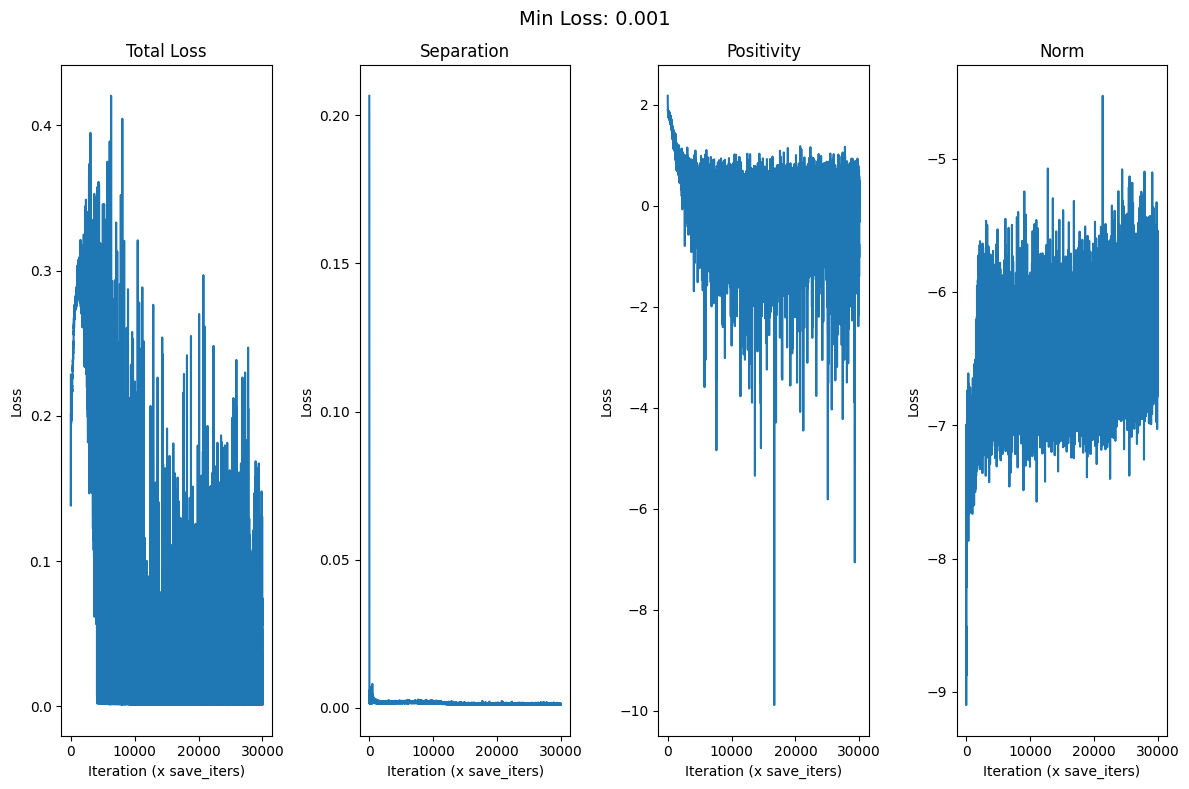

In [57]:
# Plot the loss curves
titles = ['Total Loss', 'Separation', 'Positivity', 'Norm']
fig2 = plt.figure(figsize=(12, 8))
for counter in range(4):
    plt.subplot(1, 4, counter+1)
    plt.plot(L[counter, :])
    plt.title(titles[counter])
    plt.xlabel('Iteration (x save_iters)')
    plt.ylabel('Loss')
plt.suptitle(f'Min Loss: {min_L[1]:.3f}', fontsize=14)
fig2.tight_layout()
fig2.savefig("Losses.svg")
plt.show()


Analysis of g0 (activity at origin):
  Shape: (65, 1)
  Norm: 52.92697
  Min value: -3.84024
  Max value: 20.98044
  Mean: 2.87622
  Std: 5.90116


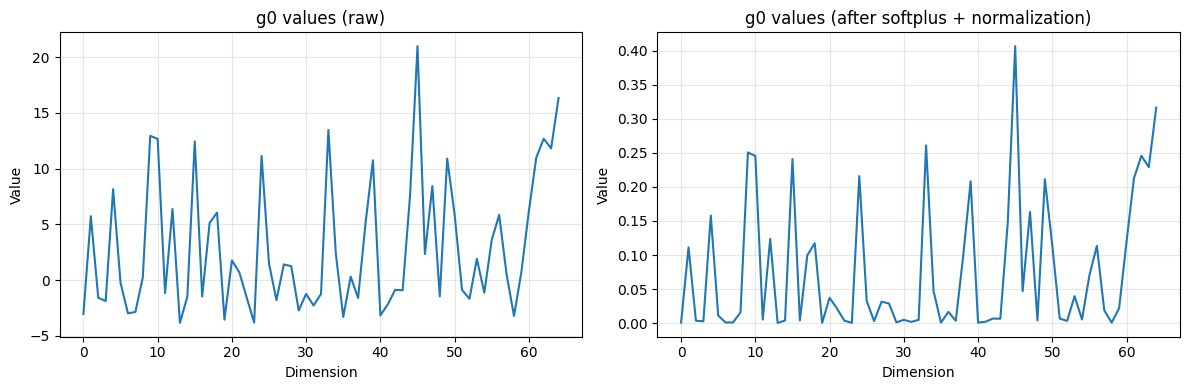

In [58]:
# Analyze g0 structure
print("\nAnalysis of g0 (activity at origin):")
print(f"  Shape: {g0.shape}")
print(f"  Norm: {np.linalg.norm(g0):.5f}")
print(f"  Min value: {np.min(g0):.5f}")
print(f"  Max value: {np.max(g0):.5f}")
print(f"  Mean: {np.mean(g0):.5f}")
print(f"  Std: {np.std(g0):.5f}")

# Plot g0 structure
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot raw g0 values
axes[0].plot(g0.flatten())
axes[0].set_xlabel('Dimension')
axes[0].set_ylabel('Value')
axes[0].set_title('g0 values (raw)')
axes[0].grid(True, alpha=0.3)

# Plot processed g0 (with softplus)
g0_processed = jax.nn.softplus(g0)
g0_processed = g0_processed / jnp.linalg.norm(g0_processed)
axes[1].plot(g0_processed.flatten())
axes[1].set_xlabel('Dimension')
axes[1].set_ylabel('Value')
axes[1].set_title('g0 values (after softplus + normalization)')
axes[1].grid(True, alpha=0.3)

fig.tight_layout()
fig.savefig("g0_structure.svg")
plt.show()


Analysis of S (change of basis matrix):
  Shape: (65, 65)
  Frobenius norm: 65.68577
  Condition number: 1925.73120
  Determinant: inf


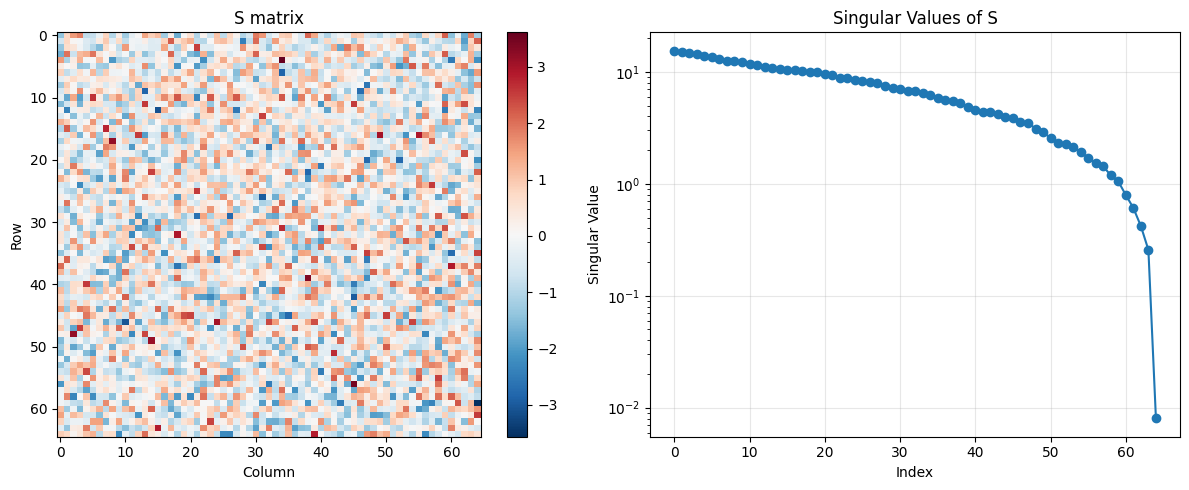

In [59]:
# Analyze S matrix structure
print("\nAnalysis of S (change of basis matrix):")
print(f"  Shape: {S.shape}")
print(f"  Frobenius norm: {np.linalg.norm(S):.5f}")
print(f"  Condition number: {np.linalg.cond(S):.5f}")
print(f"  Determinant: {np.linalg.det(S):.5f}")

# Visualize S matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im1 = axes[0].imshow(S, cmap='RdBu_r', aspect='auto')
axes[0].set_title('S matrix')
axes[0].set_xlabel('Column')
axes[0].set_ylabel('Row')
plt.colorbar(im1, ax=axes[0])

# Plot singular values
singular_values = np.linalg.svd(S, compute_uv=False)
axes[1].plot(singular_values, 'o-')
axes[1].set_xlabel('Index')
axes[1].set_ylabel('Singular Value')
axes[1].set_title('Singular Values of S')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

fig.tight_layout()
fig.savefig("S_analysis.svg")
plt.show()

<>:4: SyntaxWarning: invalid escape sequence '\o'
<>:5: SyntaxWarning: invalid escape sequence '\o'
<>:4: SyntaxWarning: invalid escape sequence '\o'
<>:5: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_133111/1855336166.py:4: SyntaxWarning: invalid escape sequence '\o'
  ax.set_xlabel('$\omega_x$', fontsize=12)
/tmp/ipykernel_133111/1855336166.py:5: SyntaxWarning: invalid escape sequence '\o'
  ax.set_ylabel('$\omega_y$', fontsize=12)


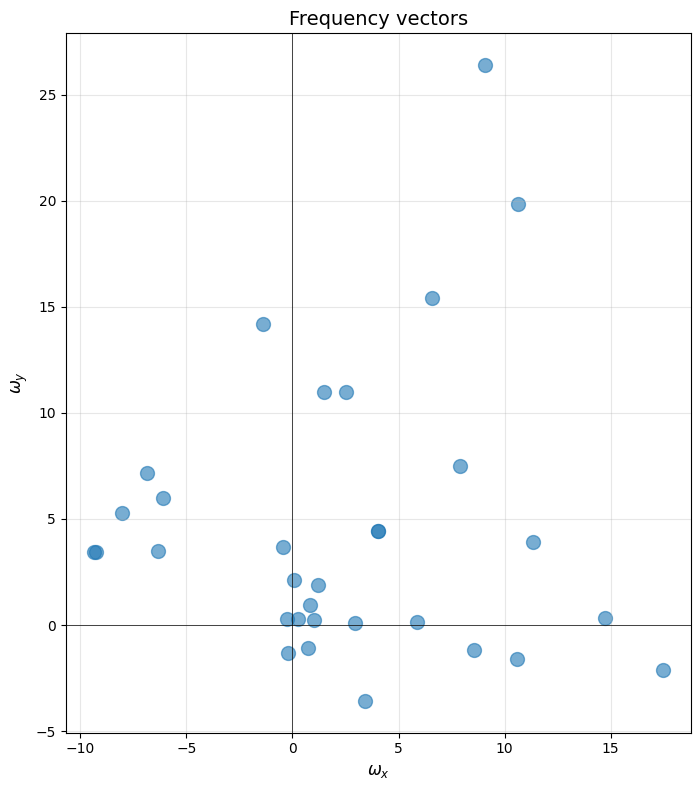


Frequency statistics:
  Number of frequencies: 32
  Mean frequency magnitude: 8.534
  Min frequency magnitude: 0.390
  Max frequency magnitude: 27.921


In [60]:
# Frequency plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(om[:, 0], om[:, 1], s=100, alpha=0.6)
ax.set_xlabel('$\omega_x$', fontsize=12)
ax.set_ylabel('$\omega_y$', fontsize=12)
ax.set_title('Frequency vectors', fontsize=14)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linewidth=0.5)
ax.axvline(x=0, color='k', linewidth=0.5)
ax.set_aspect('equal')
fig.tight_layout()
fig.savefig("freq_plot.svg")
plt.show()

# Print frequency statistics
print("\nFrequency statistics:")
print(f"  Number of frequencies: {om.shape[0]}")
freq_norms = np.linalg.norm(om, axis=1)
print(f"  Mean frequency magnitude: {np.mean(freq_norms):.3f}")
print(f"  Min frequency magnitude: {np.min(freq_norms):.3f}")
print(f"  Max frequency magnitude: {np.max(freq_norms):.3f}")

In [61]:
# Display parameters
parameters

{'D': 65,
 'T': 150000,
 'K': 1,
 'N_rand': 150,
 'N_shift': 15,
 'resample_iters': 5,
 'save_iters': 5,
 'lambda_pos_init': 0.1,
 'k_p': -9,
 'alpha_p': 0.9,
 'gamma_p': 0.0001,
 'lambda_norm_init': 0.005,
 'k_norm': 4,
 'alpha_norm': 0.9,
 'gamma_norm': 0.0001,
 'beta1': 0.9,
 'beta2': 0.9,
 'eta': 1e-08,
 'epsilon_g0': 0.1,
 'epsilon_om': 0.1,
 'epsilon_s': 0.1,
 'dim': 2,
 'sampling_choice': 1,
 'norm_size': 1,
 'Shift_std': 3,
 'shift_points_sep': 0,
 'om_init_scheme': 0,
 'om_init_scale': 2,
 'sigma_sq': 0.04,
 'sigma_theta': 0.5,
 'f': 1,
 'chi_choice': 0,
 'sep_loss_choice': 3}